## Further Ideas

### Change the Loss Function to Wasserstein Distance
[Wasserstein GANs (WGAN)](https://arxiv.org/pdf/1701.07875.pdf) are an alternative to *classical* GANs. They use a different loss function and prooved to be more stable to hyperparameter selection. While the paper offers a good theoretical introduction and reasoning why they perform better in many cases, [this article](https://wiseodd.github.io/techblog/2017/02/04/wasserstein-gan/) provides a good practical introduction

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

(70000, 28, 28)
(28, 28)
float64
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

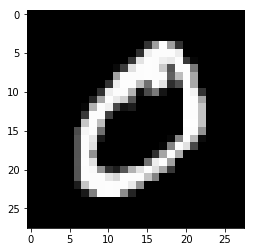

In [2]:
from tensorflow.keras.datasets.mnist import load_data
(train_X, train_y),(test_X, test_y) = load_data()

train_X = train_X/255.0
train_y = train_y/255.0

test_X = test_X/255.0
test_y = test_y/255.0


train = np.append(train_X, test_X, axis=0) #Use both Train and Testset for GAN

print(train.shape)

image = train[1]

print(image.shape)
print(image.dtype)
plt.imshow(image.reshape(28,28), cmap='gray')

print(image)

## Discriminator

In [3]:
def discriminator(X, reuse_vars=None):
    with tf.variable_scope('dis', reuse=reuse_vars):
        
        #1 Conv2d
        conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv1")

        #1 Pooling
        pool1 = tf.layers.average_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, name="pool1")

        #2 Conv2d
        conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5,5], padding="same", activation=tf.nn.relu, name="conv2")

        #2 Pooling
        pool2 = tf.layers.average_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, name="pool2")

        # Flatten
        flat_layer = tf.reshape(pool2, [-1, 7 * 7 * 64], name="flatten")

        # Dense
        dense = tf.layers.dense(inputs=flat_layer, units=1024, activation=tf.nn.relu, name="dense")

        # Logits
        logits = tf.layers.dense(inputs=dense, units=1, name="dense2")
        
        #output = tf.sigmoid(logits, name="sigmoid")
        
        return logits

## Generator

In [4]:
def gen(noise, reuse_vars=None):
    with tf.variable_scope("gen", reuse=reuse_vars):
        
        #1 Dense Layer
        dense = tf.layers.dense(inputs=noise, units=3136, activation=tf.nn.relu, name="dense_g")
        

        #Reshape
        reshape = tf.reshape(dense, [-1, 56, 56, 1], name="reshape")


        #1 Conv2d
        conv1 = tf.layers.conv2d(inputs=reshape, filters=50, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv1")

        #BatchNormalization
        conv1_norm = tf.layers.batch_normalization(conv1, name="batch_norm1")

        #Upsample
        conv1_upsample = tf.image.resize_images(conv1_norm, (56,56))


        #2 Conv2d
        conv2 = tf.layers.conv2d(inputs=conv1_upsample, filters=25, kernel_size=[3,3], strides=2, padding="same", activation=tf.nn.relu, name="conv2")

        #BatchNormalization
        conv2_norm = tf.layers.batch_normalization(conv2, name="batch_norm2")

        #Upsample
        conv2_upsample = tf.image.resize_images(conv2_norm, (56,56))


        #2 Conv2d
        logits = tf.layers.conv2d(inputs=conv2_upsample, filters=1, kernel_size=[3,3], strides=2, padding="same", name="conv3")

        output = tf.nn.sigmoid(logits, name="sigmoid")
        
        return output

## Building the GAN

In [5]:
with tf.name_scope('input'):
    real_images = tf.placeholder(tf.float32, shape=[None, 28,28,1], name="ImagePlaceholder")
    z = tf.placeholder(tf.float32, shape=[None, 100], name = "NoisePlaceholder")

In [6]:
Gz = gen(z)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [7]:
D_output_real = discriminator(real_images)
D_output_fake = discriminator(Gz, reuse_vars=True)

Instructions for updating:
Use keras.layers.average_pooling2d instead.


## Training the GAN

In [8]:
D_learning_rate = 0.0003
G_learning_rate = 0.0001

# learning_rate = 0.001 - worked so far better

In [9]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [10]:
d_vars = tf.trainable_variables(scope='dis')
g_vars = tf.trainable_variables(scope='gen')

In [11]:
D_loss = tf.reduce_mean(D_output_real) - tf.reduce_mean(D_output_fake)
G_loss = -tf.reduce_mean(D_output_fake)

In [14]:
D_solver = (tf.train.RMSPropOptimizer(learning_rate=D_learning_rate)
            .minimize(-D_loss, var_list=d_vars))
G_solver = (tf.train.RMSPropOptimizer(learning_rate=G_learning_rate)
            .minimize(G_loss, var_list=g_vars))

In [15]:
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in d_vars]

In [17]:
'''tf.summary.scalar("Dx_Loss", D_real_loss)
tf.summary.scalar("Dg_Loss", D_fake_loss)
tf.summary.scalar("D_loss", D_loss)
tf.summary.scalar("G_loss", G_loss)

tf.summary.image("Generated_Images", Gz, max_outputs=5)'''

'tf.summary.scalar("Dx_Loss", D_real_loss)\ntf.summary.scalar("Dg_Loss", D_fake_loss)\ntf.summary.scalar("D_loss", D_loss)\ntf.summary.scalar("G_loss", G_loss)\n\ntf.summary.image("Generated_Images", Gz, max_outputs=5)'

In [18]:
import datetime

now = datetime.datetime.now()

In [19]:
BATCH_SIZE = 100

BUFFER_SIZE = 140000

EPOCHS = 500000 

In [20]:
samples = []
real = []

In [21]:
#Adding config for GPU - not using all of the GPUs Memory -> leading to crashes
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8

merged = tf.summary.merge_all()

In [27]:
from tqdm import tqdm

train = train.reshape(train.shape[0], 28, 28, 1).astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices(train).repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

iterator = train_dataset.make_one_shot_iterator()

nextbatch = iterator.get_next()

init = tf.global_variables_initializer()

In [30]:
with tf.Session(config=config) as sess:
    sess.run(init)
    
    writer = tf.summary.FileWriter('./tensorboard/{0}_TrainableVariables_500K-Epochs'.format(now.strftime("%Y_%m_%d-%H-%M")), sess.graph)
    
    for pretrain in tqdm(range(20)):
        batch_images = sess.run(nextbatch)

        batch_z = np.random.uniform(-1,1,size=(BATCH_SIZE,100))

        _ = sess.run(D_solver, feed_dict={real_images:batch_images, z:batch_z})
    
    
    for epoch in tqdm(range(EPOCHS)):
        batch_z = np.random.uniform(-1,1,size=(BATCH_SIZE,100))
        print(clip_D)
        for _ in range(5):
            batch_images = sess.run(nextbatch)            
            D_summary, _, discrloss, discr_r_loss, discr_f_loss = sess.run([merged, D_solver, D_loss, clip_D], feed_dict={real_images:batch_images, z:batch_z})

        genloss, _ = sess.run([G_loss, G_solver], feed_dict={z:batch_z})

        if (epoch % 10 == 0):{
            # SUMMARIES
            writer.add_summary(D_summary, epoch)     
            
        }

        
        
        if (epoch%50 == 0):
            sample_z = np.random.uniform(-1,1,size=(1,100))
            
            gen_sample = sess.run(gen(z, reuse_vars=True), feed_dict={z: sample_z})
        
            samples.append(gen_sample)
            
            plt.imshow(gen_sample.reshape(28,28), cmap="gray")
            plt.show()
        



  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

  5%|████▏                                                                              | 1/20 [00:31<10:03, 31.76s/it]

 10%|████████▎                                                                          | 2/20 [00:31<06:40, 22.27s/it]

 15%|████████████▍                                                                      | 3/20 [00:32<04:25, 15.63s/it]

 20%|████████████████▌                                                                  | 4/20 [00:32<02:55, 10.98s/it]

 25%|████████████████████▊                                                              | 5/20 [00:32<01:55,  7.72s/it]

 30%|████████████████████████▉                                                          | 6/20 [00:32<01:16,  5.44s/it]

 35%|█████████████████████████████                                                      | 7/20 [00:32<00:50,  3.85s/it]

 40%|█████████████████████████

[<tf.Tensor 'Assign:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Tensor 'Assign_1:0' shape=(32,) dtype=float32_ref>, <tf.Tensor 'Assign_2:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Tensor 'Assign_3:0' shape=(64,) dtype=float32_ref>, <tf.Tensor 'Assign_4:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Tensor 'Assign_5:0' shape=(1024,) dtype=float32_ref>, <tf.Tensor 'Assign_6:0' shape=(1024, 1) dtype=float32_ref>, <tf.Tensor 'Assign_7:0' shape=(1,) dtype=float32_ref>]


TypeError: Fetch argument None has invalid type <class 'NoneType'>